In [2]:
%matplotlib inline

In [3]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.interpolate import interp1d
import scipy.stats as st
from vtk_rw import read_vtk
import seaborn as sns

/home/raid3/huntenburg/workspace/anaconda2/envs/myelinconnect/lib/python2.7/site-packages/IPython/html.py:14: ShimWarning: The `IPython.html` package has been deprecated. You should import from `notebook` instead. `IPython.html.widgets` has moved to `ipywidgets`.
  "`IPython.html.widgets` has moved to `ipywidgets`.", ShimWarning)


In [5]:
def hist_match(source, template):
    """
    Adjust the pixel values of a grayscale image such that its histogram
    matches that of a target image

    Arguments:
    -----------
        source: np.ndarray
            Image to transform; the histogram is computed over the flattened
            array
        template: np.ndarray
            Template image; can have different dimensions to source
    Returns:
    -----------
        matched: np.ndarray
            The transformed output image
    """

    oldshape = source.shape
    source = source.ravel()
    template = template.ravel()

    # get the set of unique pixel values and their corresponding indices and
    # counts
    s_values, bin_idx, s_counts = np.unique(source, return_inverse=True,
                                            return_counts=True)
    t_values, t_counts = np.unique(template, return_counts=True)

    # take the cumsum of the counts and normalize by the number of pixels to
    # get the empirical cumulative distribution functions for the source and
    # template images (maps pixel value --> quantile)
    s_quantiles = np.cumsum(s_counts).astype(np.float64)
    s_quantiles /= s_quantiles[-1]
    t_quantiles = np.cumsum(t_counts).astype(np.float64)
    t_quantiles /= t_quantiles[-1]

    # interpolate linearly to find the pixel values in the template image
    # that correspond most closely to the quantiles in the source image
    interp_t_values = np.interp(s_quantiles, t_quantiles, t_values)

    return interp_t_values[bin_idx].reshape(oldshape)

In [18]:
_,_,source = read_vtk('/scr/ilz3/myelinconnect/new_groupavg/model/random_data/smooth_12/lh_random_normal_0_smoothdata.vtk')
source = np.squeeze(source)
target = np.load('/scr/ilz3/myelinconnect/new_groupavg/t1/smooth_3/lh_t1_avg_smooth_3.npy')

In [19]:
mask = np.load('/scr/ilz3/myelinconnect/new_groupavg/masks/lh_fullmask_new.npy')
mask= np.unique(np.concatenate((mask, np.where(target<1500)[0])))

In [20]:
target = np.delete(target, mask)
source = np.delete(source, mask)

In [21]:
matched_source = hist_match(source, target)

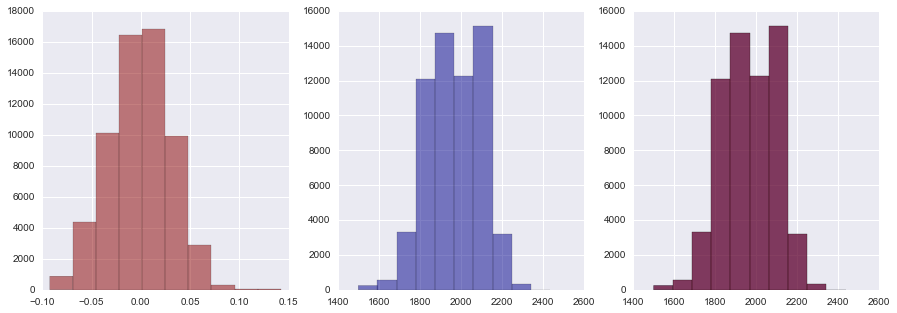

In [22]:
fig=plt.figure(figsize=(15,5))
fig.add_subplot(131)
plt.hist(source, alpha=0.5, color="darkred");
fig.add_subplot(132)
plt.hist(target, alpha=0.5, color="darkblue");
fig.add_subplot(133)
plt.hist(target, alpha=0.5, color="darkblue");
plt.hist(matched_source, alpha=0.5, color="darkred");

In [23]:
v,f,_=read_vtk('/scr/ilz3/myelinconnect/new_groupavg/surfs/lowres/inflated/lh_lowres_new_infl50.vtk')
sulc = np.load('/scr/ilz3/myelinconnect/new_groupavg/surfs/lowres/sulc/lh_sulc.npy')

In [24]:
def plot_inflated(data, v, f, sulc, thr=1e-50, vmin=None, vmax=None, symmetric=False, figsize=(10,9),  cmap='coolwarm'):
    
    from plotting import plot_surf_stat_map, crop_img
    
    if vmin==None:
        vmin=np.nanmin(data)
    if vmax==None:
        vmax=np.nanmax(data)
        
    
    sns.set_style('white')
    lat=plot_surf_stat_map(v, f, stat_map=data, bg_map=sulc, bg_on_stat=True, darkness=0.4, 
                        elev=180,azim=0, figsize=figsize ,threshold=thr, cmap=cmap, 
                        symmetric_cbar=symmetric, vmin=vmin, vmax=vmax) 

    med=plot_surf_stat_map(v, f, stat_map=data, bg_map=sulc, bg_on_stat=True,darkness=0.4,
            elev=180,azim=180, figsize=figsize, threshold=thr, cmap=cmap, 
                           symmetric_cbar =symmetric, vmin=vmin, vmax=vmax) 

    lat_crop=crop_img(lat)
    med_crop=crop_img(med)

    fig=plt.figure()
    fig.set_size_inches(16, 8)
    ax1 = fig.add_subplot(121)
    plt.imshow(lat_crop)
    ax1.set_axis_off()
    ax2 = fig.add_subplot(122)
    plt.imshow(med_crop)
    ax2.set_axis_off()
    
    return fig

In [25]:
idcs = np.arange(0,v.shape[0])
nonmask = np.delete(idcs, mask)

In [39]:
source_plot = np.zeros((v.shape[0],))
source_plot[nonmask] = source
matched_source_plot = np.zeros((v.shape[0],))
matched_source_plot[nonmask] = matched_source
target_plot = np.zeros((v.shape[0],))
target_plot[nonmask] = target

### unmatched random data

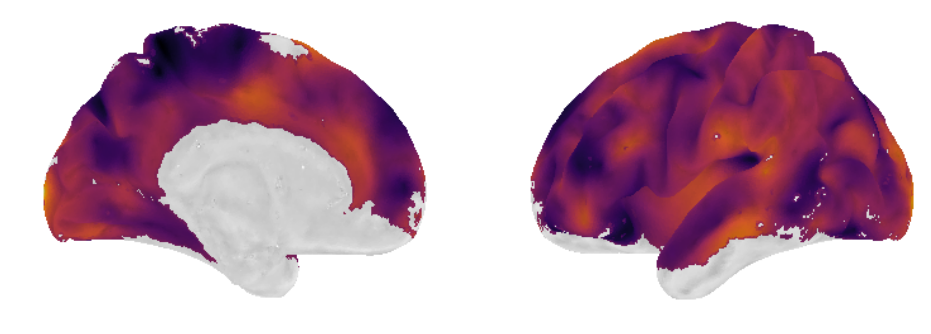

In [54]:
plot=plot_inflated(source_plot, v, f, sulc, cmap='inferno')

### matched random data

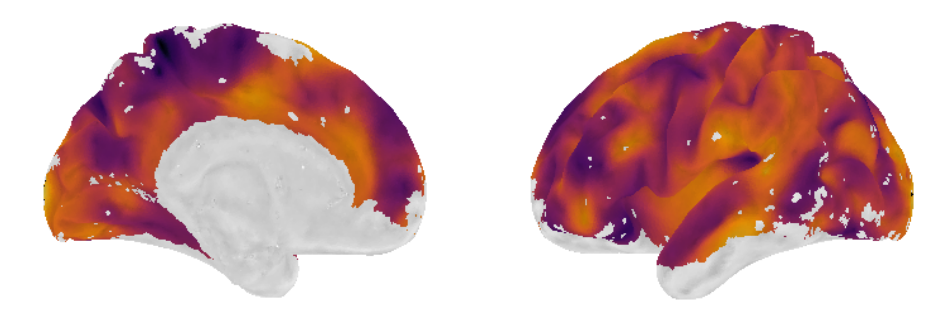

In [55]:
plot=plot_inflated(matched_source_plot, v, f, sulc, cmap='inferno', 
                   vmin=1500, vmax=2400, thr=1500)

### original data

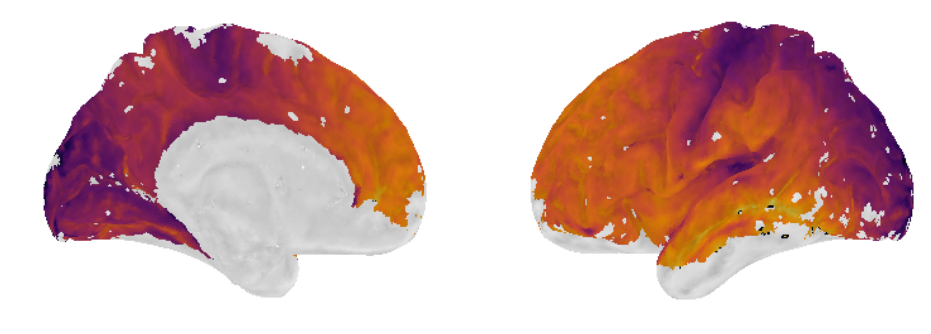

In [53]:
plot=plot_inflated(target_plot, v, f, sulc, cmap='inferno', 
                   vmin=1500, vmax=2400, thr=1500)